In [6]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import warnings
import statistics 
import matplotlib.patches as mpatches
## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo, IntervalLinearizedPosition, IntervalPositionInfo, TrackGraph)
from spyglass.common.common_interval import interval_list_intersect

from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_pos_timestamp,get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)
from coherence import (multitaper_and_connectivity,get_signal_from_trialtimes, get_CI)
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity
from spectral_connectivity.statistics import fisher_z_transform
from spectral_connectivity.statistics import coherence_bias


warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [77]:
# nwb_file_name = 'senor20201030_.nwb'
nwb_file_name = 'j1620210710_.nwb'

In [78]:
#get LFP data
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])

In [9]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'

trial_data = pd.read_csv(filename)
trial_data

trial_data['stem_switch'] = trial_data['stem'].ne(trial_data['stem'].shift())

#will also set the first trial of every session to be a stem switch
for ix in range(trial_data.index.min(), trial_data.index.max()+1): 
    if trial_data.loc[ix,'trial_number_by_epoch']==0:
        trial_data.loc[ix,'stem_switch']= True
    #not sure if this does anything? 
trial_data

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [10]:
electrode_id = [8,17,40,132,244,300]

sampling_rate = sampling_frequency = 1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None

In [11]:
#this cell will get the times of the segment switch for all trials for all epochs. will add them to the df
#uses the poke in and poke out times from the df, compares to the seg switch times from the pos data. 

epoch_pos = [[2, 1],[4,8],[6 , 10],[8 ,12],[10,14],[12,3],[14,5]]


list_seg_switch=[]

#for each epoch
for epoch in range(2,16,2):
    #seperate 1 epoch
    #load the trial data for each epoch individually just to compare trial times and pos times which are by the epoch 
    trial_data_sesh = trial_data[trial_data.epoch==epoch]
    
    #get the start/stop trial times
    trial_times=[]
    #for each session, find the poke in and out times, save those to a list
    for ix in range(1,len(trial_data_sesh)):
        trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix].poke_in_ts
        trial_times.append([trial_start, trial_end])
    
    #use the epoch pos from above to get the corresponding pos # for the epoch, frm the pic alison send to me
    #if this wasnt correct, the code would break so thats a relief! 
    
    for ix in range(len(epoch_pos)):
        if epoch_pos[ix][0]==epoch:
            pos_num = epoch_pos[ix][1]
    
    #get the position and linearized position info for that epoch 
    position_info = (IntervalPositionInfo() &
                     {'nwb_file_name': nwb_file_name,
                      'interval_list_name': f'pos {pos_num} valid times',
                      'position_info_param_name': 'default'}
                    ).fetch1_dataframe()
    # position_info

    linear_position_df= (IntervalLinearizedPosition() &
                         {'position_info_param_name': 'default',
                          'nwb_file_name': nwb_file_name,
                          'interval_list_name': f'pos {pos_num} valid times',
                          'track_graph_name': 'senor20201030',
                          'linearization_param_name': 'default',
                         }).fetch1_dataframe()
    # linear_position_df
    #get the track segment switch times from linearized position
    linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())
    
    seg_switch_times = linear_position_df[linear_position_df.track_segment_id_switch==True].index
    
    #find the segement switch times for each trial individually 
    trials_seg_switch_times = []
    for ix in range(len(trial_times)):
        #one inidividual trials start and end times 
        trial_start = trial_times[ix][0]
        trial_end = trial_times[ix][1]
        #find the segment switch time that falls within those trial times 
        switch_time_ind_s = seg_switch_times>=trial_start
        switch_time_ind_e = seg_switch_times<=trial_end
        trial_switch_times = seg_switch_times[switch_time_ind_s & switch_time_ind_e]
        #make it into a new list- for each trial, each now has a list of 1+ segment switch times  
        trials_seg_switch_times.append(trial_switch_times)
        
    #add a 0 to make it the same length as the df 
    list_seg_switch.append(0)
# add these segment switch times to a new list, which will be added to the total df. this might be a little redundant. 
    for ix in range(len(trials_seg_switch_times)):
        seg_switch_times = trials_seg_switch_times[ix]
        if len(seg_switch_times)==1:
            list_seg_switch.append([seg_switch_times[0]])
        else: 
            list_seg_switch.append(seg_switch_times[0:].tolist())
trial_data['seg_switch_times']=list_seg_switch

In [12]:
#for various halflives, get the leaf, stem, and epoch(global) grouped EWM. 

for halflife in [3,10,20]:
    obj = ['epoch','stem','leaf']
    trial_data[f'rew_rate_ewm_leaf_half_{halflife}'] =trial_data.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
    obj = ['epoch','stem']
    trial_data[f'rew_rate_ewm_stem_half_{halflife}'] =trial_data.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
    obj = ['epoch']
    trial_data[f'rew_rate_ewm_epoch_half_{halflife}'] =trial_data.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())

In [13]:
#get a column that has the nominal probability of reward for whichever leaf hes going towards. to get nominal rew prob instead of ewm. 
current_leaf_prob=[]
for ix in range(len(trial_data)):
    current_leaf = trial_data.iloc[ix].leaf
    current_leaf_prob.append(trial_data.iloc[ix][f'p_rew_leaf{current_leaf}'])
trial_data['current_leaf_prob'] = current_leaf_prob

In [14]:
#get contingency number - hard coded. 
num_trials_per_contingency = 60

cont_num=[]
for ix in range(len(trial_data)):
    if trial_data.iloc[ix].trial_number_by_epoch <num_trials_per_contingency:
        cont_num.append(1)
    if trial_data.iloc[ix].trial_number_by_epoch >=num_trials_per_contingency:
        if trial_data.iloc[ix].trial_number_by_epoch < 2*num_trials_per_contingency:
            cont_num.append(2)
    if trial_data.iloc[ix].trial_number_by_epoch >= 2*num_trials_per_contingency: 
        cont_num.append(3)
trial_data['cont_num'] = cont_num




In [15]:
#get bout number and bout length grouped by epoch. 

epoch_data=[]
for ix in range(0,trial_data.epoch.max()+2,2):
    epoch_df = trial_data[trial_data.epoch==ix]
    epoch_data.append(epoch_df['stem'].ne(epoch_df['stem'].shift()).cumsum().tolist())
mylist = [item for sublist in epoch_data for item in sublist]
trial_data['bout_num'] = mylist

bout_len=[]
for ix in range(2,trial_data.epoch.max()+2,2):
    epoch_df = trial_data[trial_data.epoch==ix]
    for bout in range(1,int(epoch_df.bout_num.max()+1)):
        bout_len.append(len(epoch_df[epoch_df.bout_num == bout]))

bout_len_tracker=[]
for ix in range(len(bout_len)):
    bout_len_ix = bout_len[ix]
    bout_len_tracker.append((bout_len_ix*(np.ones(bout_len_ix))).tolist())

# bout_len_tracker
mylist = [item for sublist in bout_len_tracker for item in sublist]
trial_data['bout_lens_per_bout'] = mylist

trial_data

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_ewm_leaf_half_10,rew_rate_ewm_stem_half_10,rew_rate_ewm_epoch_half_10,rew_rate_ewm_leaf_half_20,rew_rate_ewm_stem_half_20,rew_rate_ewm_epoch_half_20,current_leaf_prob,cont_num,bout_num,bout_lens_per_bout
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20,1,1,2.0
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20,1,1,2.0
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50,1,2,6.0
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1.000000,0.523810,0.286792,1.000000,0.512195,0.268583,80,1,2,6.0
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.523810,0.697885,0.457830,0.512195,0.682791,0.429477,50,1,2,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,0.518466,0.376674,0.407259,0.484233,0.423502,0.392555,50,3,13,11.0
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,0.391401,0.433614,0.461145,0.442383,0.452865,0.421487,50,3,13,11.0
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,0.565187,0.485330,0.510132,0.516675,0.480641,0.449039,50,3,13,11.0
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,0.450451,0.532305,0.554665,0.477458,0.506923,0.475280,50,3,13,11.0


## stay trials

<ErrorbarContainer object of 3 artists>

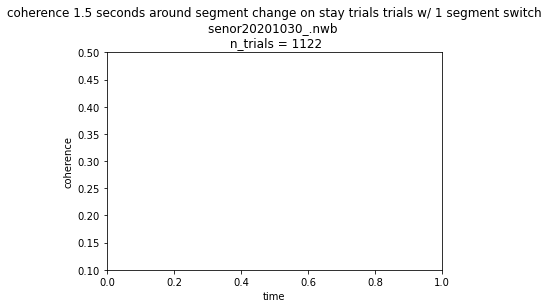

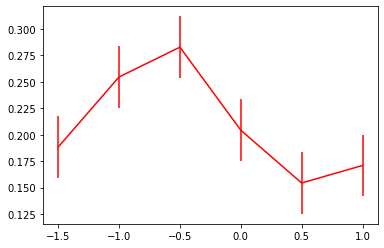

In [42]:
#Stay trials with only 1 segment switch, over whole day

coher_keeper=[]
time_at_center = []

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                time_at_center.append(trial_data.iloc[ix].seg_switch_times[0])

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
    
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])


# plt.plot(time,coher_keeper[0])
 

plt.figure()
plt.errorbar(time,coher_keeper[0],
            yerr=ci_pos,
            color = 'r')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(.1,.5)   
# plt.errorbar(time,z_transform,
#             yerr=ci_pos,
#             color = 'r')
# plt.title('z transformed coherence with error bars')
# plt.xlabel('time') 
# plt.ylabel('z transformed coherence')   

## stay trials more than one segment switch 

(0.1, 0.5)

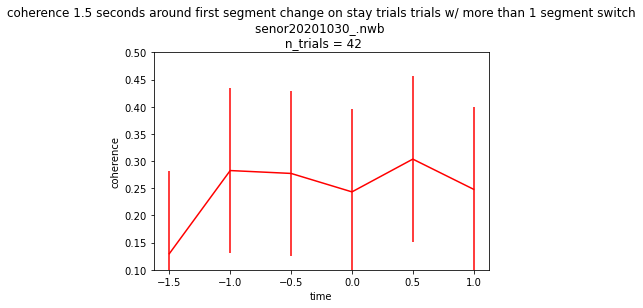

In [35]:
#Stay trials with only 1 segment switch, over whole day

coher_keeper=[]
time_at_center = []

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) !=1:
                time_at_center.append(trial_data.iloc[ix].seg_switch_times[0])

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
    
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

plt.errorbar(time,coher_keeper[0],
            yerr=ci_pos,
            color = 'r')
plt.title(f'coherence {time_b4} seconds around first segment change on stay trials trials w/ more than 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence') 
plt.ylim(.1,.5)   
# plt.plot(time,coher_keeper[0])
# plt.title(f'coherence {time_b4} seconds around first segment change on stay trials trials w/ more than 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
# plt.xlabel('time') 
# plt.ylabel('coherence')                
# plt.ylim(.1,.5)    

# plt.figure()
# plt.errorbar(time,z_transform,
#             yerr=ci_pos,
#             color = 'r')
# plt.title('z transformed coherence with error bars')
# plt.xlabel('time') 
# plt.ylabel('z transformed coherence')  

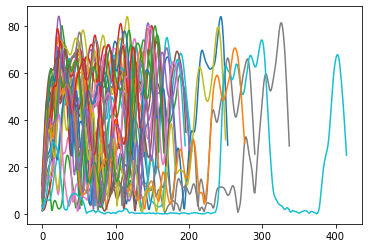

In [ ]:
# #evaluating the length of switch trials, with or without exactly 3 segment switches 
# speed_keeper=[]
# for ix in range(1,len(trial_data)): 
#     if trial_data.iloc[ix].seg_switch_times!=0:
#         if trial_data.iloc[ix].stem_switch==True: 
#             if len(trial_data.iloc[ix].seg_switch_times) !=3:
#             # trial_keeper_middle.append(trial_data.iloc[ix].seg_switch_times[1])
#                 trial_start = trial_data.iloc[ix-1].poke_out_ts
#                 trial_end = trial_data.iloc[ix].poke_in_ts
#                 epoch= trial_data.iloc[ix].epoch
#                 for epoch_ix in range(len(epoch_pos)):
#                     if epoch_pos[epoch_ix][0]==epoch:
#                         pos_num = epoch_pos[epoch_ix][1]

#         #get the position and linearized position info for that epoch 
#                 position_info = (IntervalPositionInfo() &
#                                      {'nwb_file_name': nwb_file_name,
#                                       'interval_list_name': f'pos {pos_num} valid times',
#                                       'position_info_param_name': 'default'}
#                                     ).fetch1_dataframe()
#                 speed_x,speed_y = get_speed_timestamp(trial_start,trial_end,position_info)
#                 speed_keeper.append([speed_y])
#                 plt.plot(range(len(speed_x)),speed_y)



## switch trials with exactly 3 segment changes 

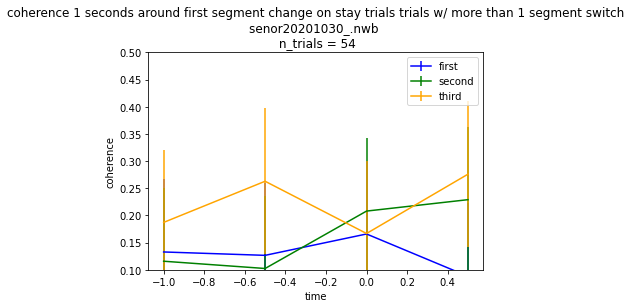

In [41]:
#switch trials with exactly 3 segment switches (no vte) 

coher_keeper_first=[]


trial_keeper_first=[]
trial_keeper_second=[]
trial_keeper_third=[]


for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==True: 
            if len(trial_data.iloc[ix].seg_switch_times) ==3:
                trial_keeper_first.append(trial_data.iloc[ix].seg_switch_times[0])
                trial_keeper_second.append(trial_data.iloc[ix].seg_switch_times[1])
                trial_keeper_third.append(trial_data.iloc[ix].seg_switch_times[2])

time_b4 = time_after = 1
electrode_id_temp =[8,132]

    
signal_first = get_signal_from_trialtimes(trial_keeper_first, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_second = get_signal_from_trialtimes(trial_keeper_second, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_third = get_signal_from_trialtimes(trial_keeper_third, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal_first,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_first.append(coh_seg[0])
ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)


# plt.plot(time,coher_keeper_first[0],label='first')
# # plt.title(f'coherence 2 seconds around center segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
# plt.xlabel('time') 
# plt.ylabel('coherence')

plt.errorbar(time,coher_keeper_first[0],
            yerr=ci_pos,
            color = 'blue',label='first')
plt.title(f'coherence {time_b4} seconds around first segment change on stay trials trials w/ more than 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence') 
plt.ylim(.1,.5)   


coher_keeper_second=[]
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal_second,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_second.append(coh_seg[0])
ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)


plt.errorbar(time,coher_keeper_second[0],
            yerr=ci_pos,
            color = 'green',label='second')
plt.title(f'coherence {time_b4} seconds around first segment change on stay trials trials w/ more than 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence') 
plt.ylim(.1,.5) 


# plt.plot(time,coher_keeper_second[0],label='second')
# # plt.title(f'coherence 2 seconds around center segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
# plt.xlabel('time') 
# plt.ylabel('coherence')
# # plt.ylim(.1,.5)

# plt.figure()
# plt.errorbar(time,z_transform,
#             yerr=ci_pos,
#             color = 'r')
# plt.title('z transformed coherence with error bars')
# plt.xlabel('time') 
# plt.ylabel('z transformed coherence')
coher_keeper_third=[]
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal_third,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_third.append(coh_seg[0])

ci_pos, ci_neg = get_CI(z_transform, n_trials, num_tapers)

plt.errorbar(time,coher_keeper_third[0],
            yerr=ci_pos,
            color = 'orange',label='third')
plt.title(f'coherence {time_b4} seconds around first segment change on stay trials trials w/ more than 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence') 
plt.ylim(.1,.5) 
plt.legend()

# plt.plot(time,coher_keeper_third[0],label='third')
# plt.title(f'coherence  1 second around each segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
# plt.xlabel('time') 
# plt.ylabel('coherence')
# plt.ylim(.1,.5)
# plt.legend()



## switch trials with more than 3 segment switches 

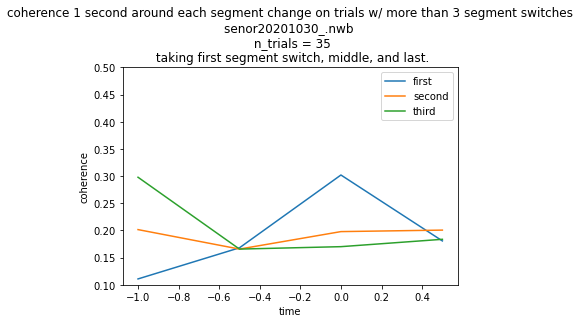

In [71]:
#switch trials with more than 3 segment switches- taking the first, midle, and last of them 

coher_keeper_first=[]


trial_keeper_first=[]
trial_keeper_second=[]
trial_keeper_third=[]


for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==True: 
            if len(trial_data.iloc[ix].seg_switch_times) !=3:
                trial_keeper_first.append(trial_data.iloc[ix].seg_switch_times[0])
                trial_keeper_second.append(trial_data.iloc[ix].seg_switch_times[int(len(trial_data.iloc[1249].seg_switch_times)/2)])
                trial_keeper_third.append(trial_data.iloc[ix].seg_switch_times[-1])

time_b4 = time_after = 1
electrode_id_temp =[8,132]

    
signal_first = get_signal_from_trialtimes(trial_keeper_first, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_second = get_signal_from_trialtimes(trial_keeper_second, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_third = get_signal_from_trialtimes(trial_keeper_third, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal_first,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_first.append(coh_seg[0])
plt.plot(time,coher_keeper_first[0],label='first')
# plt.title(f'coherence 2 seconds around center segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence')
# plt.ylim(.1,.5)

# plt.figure()
# plt.errorbar(time,z_transform,
#             yerr=ci_pos,
#             color = 'r')
# plt.title('z transformed coherence with error bars')
# plt.xlabel('time') 
# plt.ylabel('z transformed coherence')
coher_keeper_second=[]
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal_second,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_second.append(coh_seg[0])
plt.plot(time,coher_keeper_second[0],label='second')
# plt.title(f'coherence 2 seconds around center segment change on trials w/ 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}')
plt.xlabel('time') 
plt.ylabel('coherence')
# plt.ylim(.1,.5)

# plt.figure()
# plt.errorbar(time,z_transform,
#             yerr=ci_pos,
#             color = 'r')
# plt.title('z transformed coherence with error bars')
# plt.xlabel('time') 
# plt.ylabel('z transformed coherence')
coher_keeper_third=[]
time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal_third,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_third.append(coh_seg[0])
plt.plot(time,coher_keeper_third[0],label='third')
plt.title(f'coherence 1 second around each segment change on trials w/ more than 3 segment switches\n{nwb_file_name} \n n_trials = {n_trials}\n taking first segment switch, middle, and last.')
plt.xlabel('time') 
plt.ylabel('coherence')
plt.ylim(.1,.5)
plt.legend()

## stay trials cross epoch 

(0.0, 0.5)

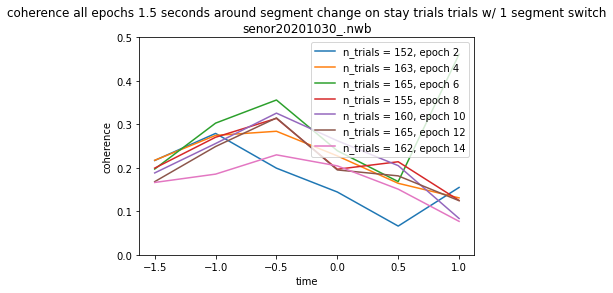

In [75]:
time_at_center = []
for epoch in range(2,trial_data.epoch.max()+2,2):
    coher_keeper=[]


    time_at_center = []
    trial_data_epoch= trial_data[trial_data.epoch==epoch]
    for ix in range(1,len(trial_data_epoch)): 
        if trial_data_epoch.iloc[ix].seg_switch_times!=0:
            if trial_data_epoch.iloc[ix].stem_switch==False: 
                if len(trial_data_epoch.iloc[ix].seg_switch_times) ==1:
                    time_at_center.append(trial_data_epoch.iloc[ix].seg_switch_times[0])

    time_b4 = time_after = 1.5
    electrode_id_temp =[8,132]


    signal = get_signal_from_trialtimes(time_at_center, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)



    time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
    coher_keeper=[]


    coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
    coher_keeper.append(coh_seg[0])


    # plt.figure()
    plt.plot(time,coher_keeper[0],label= f'n_trials = {n_trials}, epoch {epoch}')
 
    plt.legend()
plt.title(f'coherence all epochs {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name}')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5) 



## Stay trials Cross Stem

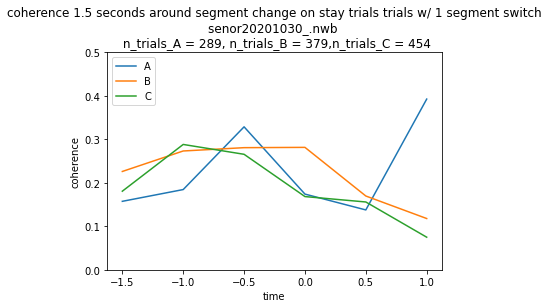

In [78]:
coher_keeper_A=[]
coher_keeper_B=[]
coher_keeper_C=[]


time_at_center_A = []
time_at_center_B = []
time_at_center_C = []


# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].stem=='A':
                    time_at_center_A.append(trial_data.iloc[ix].seg_switch_times[0])
                if trial_data.iloc[ix].stem=='B':
                    time_at_center_B.append(trial_data.iloc[ix].seg_switch_times[0])
                if trial_data.iloc[ix].stem=='C':
                    time_at_center_C.append(trial_data.iloc[ix].seg_switch_times[0])


time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_A = get_signal_from_trialtimes(time_at_center_A, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
time, freq, mag, power,n_trials_A,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_A,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_A.append(coh_seg[0])

plt.plot(time,coher_keeper_A[0],label='A')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n stem={stem}')
# plt.xlabel('time') 
# plt.ylabel('coherence')                
# plt.ylim(0,.5)        
         
    
signal_B = get_signal_from_trialtimes(time_at_center_B, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
time, freq, mag, power,n_trials_B,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_B,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_B.append(coh_seg[0])

plt.plot(time,coher_keeper_B[0],label='B')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n stem={stem}')
# plt.xlabel('time') 
# plt.ylabel('coherence')                
# plt.ylim(0,.5)    

signal_C = get_signal_from_trialtimes(time_at_center_C, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
time, freq, mag, power,n_trials_C,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_C,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_C.append(coh_seg[0])

plt.plot(time,coher_keeper_C[0],label='C')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_A = {n_trials_A}, n_trials_B = {n_trials_B},n_trials_C = {n_trials_C}')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
plt.legend()

## Split by Value- leaf, halflife = 3

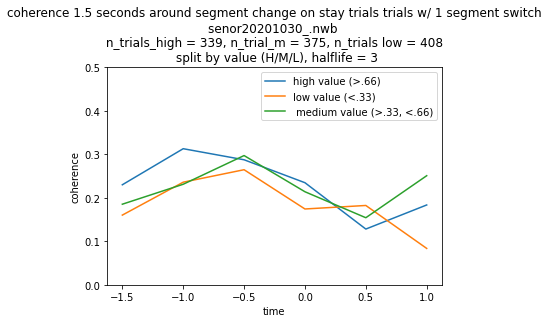

In [81]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_leaf_half_3>.66:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_leaf_half_3<.33: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0],label='high value (>.66)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]


# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label='low value (<.33)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]


time, freq, mag, power,n_trials_low,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label=' medium value (>.33, <.66)')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by value (H/M/L), halflife = 3')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

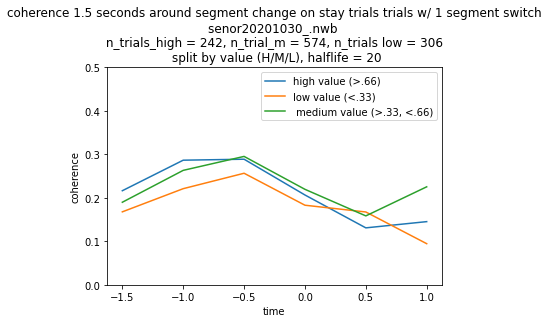

In [80]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_leaf_half_20>.66:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_leaf_half_20<.33: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high_v,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])



plt.plot(time,coher_keeper[0],label='high value (>.66)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]


# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials_low,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label='low value (<.33)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]


time, freq, mag, power,n_trials,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0],label=' medium value (>.33, <.66)')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high_v}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by value (H/M/L), halflife = 20')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

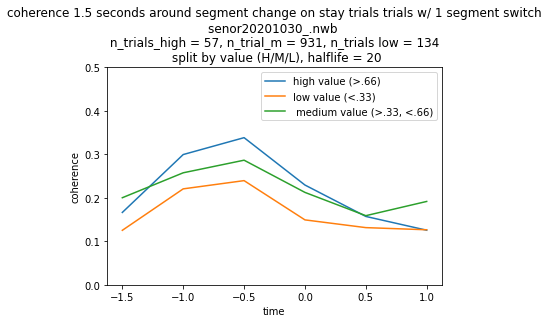

In [82]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_epoch_half_20>.66:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_epoch_half_20<.33: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high_v,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

plt.plot(time,coher_keeper[0],label='high value (>.66)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]

# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials_low,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label='low value (<.33)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]

time, freq, mag, power,n_trials,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label=' medium value (>.33, <.66)')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high_v}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by value (H/M/L), halflife = 20')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

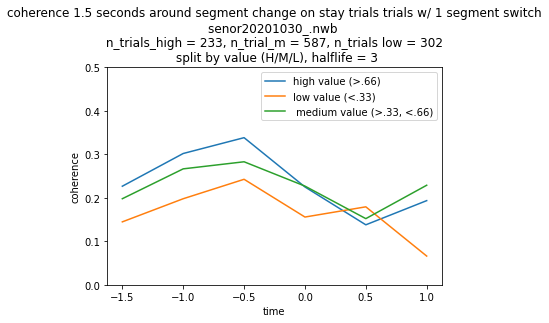

In [84]:
coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_epoch_half_3>.66:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_epoch_half_3<.33: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high_v,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

plt.plot(time,coher_keeper[0],label='high value (>.66)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]

# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials_low,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label='low value (<.33)')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]

time, freq, mag, power,n_trials,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label=' medium value (>.33, <.66)')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high_v}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by value (H/M/L), halflife = 3')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

In [95]:
rews=[]
for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                rews.append(trial_data.iloc[ix].rew_rate_ewm_epoch_half_3)
rews.sort()
len_rews = len(rews)
cutoffs = int(len_rews/3) 
lower_cutoff = rews[cutoffs]
upper_cutoff = rews[2*cutoffs]

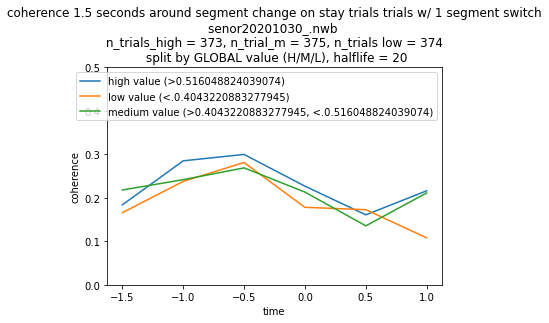

In [99]:

rews=[]
for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                rews.append(trial_data.iloc[ix].rew_rate_ewm_epoch_half_20)
rews.sort()
len_rews = len(rews)
cutoffs = int(len_rews/3) 
lower_cutoff = rews[cutoffs]
upper_cutoff = rews[2*cutoffs]



coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_epoch_half_20>upper_cutoff:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_epoch_half_20<lower_cutoff: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high_v,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

plt.plot(time,coher_keeper[0],label=f'high value (>{upper_cutoff})')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]

# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials_low,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label=f'low value (<.{lower_cutoff})')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]

time, freq, mag, power,n_trials,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label=f'medium value (>{lower_cutoff}, <.{upper_cutoff})')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high_v}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by GLOBAL value (H/M/L), halflife = 20')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

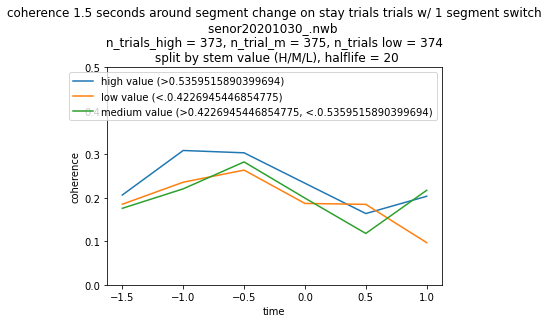

In [103]:

rews=[]
for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                rews.append(trial_data.iloc[ix].rew_rate_ewm_stem_half_20)
rews.sort()
len_rews = len(rews)
cutoffs = int(len_rews/3) 
lower_cutoff = rews[cutoffs]
upper_cutoff = rews[2*cutoffs]



coher_keeper=[]
time_at_center_high_v = []
time_at_center_medium_v=[]
time_at_center_low_v=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].rew_rate_ewm_stem_half_20>upper_cutoff:
                    time_at_center_high_v.append(trial_data.iloc[ix].seg_switch_times[0])
                elif  trial_data.iloc[ix].rew_rate_ewm_stem_half_20<lower_cutoff: 
                    time_at_center_low_v.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_medium_v.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal = get_signal_from_trialtimes(time_at_center_high_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_low = get_signal_from_trialtimes(time_at_center_low_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_medium = get_signal_from_trialtimes(time_at_center_medium_v, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_high_v,z_transform_high,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

plt.plot(time,coher_keeper[0],label=f'high value (>{upper_cutoff})')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]

# time, freq, mag, power,n_trials_low = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
time, freq, mag, power,n_trials_low,z_transform_low,num_tapers = multitaper_and_connectivity(signal_low,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label=f'low value (<.{lower_cutoff})')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n  lowvalue (<.33)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)     


coher_keeper=[]

time, freq, mag, power,n_trials,z_transform_medium,num_tapers = multitaper_and_connectivity(signal_medium,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
ci_pos_medium, ci_neg_medium = get_CI(z_transform_medium, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])

# plt.figure()
plt.plot(time,coher_keeper[0],label=f'medium value (>{lower_cutoff}, <.{upper_cutoff})')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_high = {n_trials_high_v}, n_trial_m = {n_trials}, n_trials low = {n_trials_low} \n split by stem value (H/M/L), halflife = 20')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

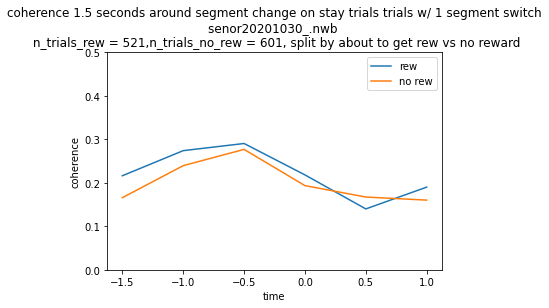

In [18]:
#coherence when hes about to get reward vs not

coher_keeper_rew=[]
time_at_center_rew = []
time_at_center_no_rew=[]

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].reward==1:
                    time_at_center_rew.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_no_rew.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_rew = get_signal_from_trialtimes(time_at_center_rew, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_no_rew = get_signal_from_trialtimes(time_at_center_no_rew, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_rew,z_transform_rew,num_tapers = multitaper_and_connectivity(signal_rew,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
# ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_rew.append(coh_seg[0])

plt.plot(time,coher_keeper_rew[0],label=f'rew')
     
               
    
coher_keeper_no_rew=[]

time, freq, mag, power,n_trials_no_rew,z_transform_np_rew,num_tapers = multitaper_and_connectivity(signal_no_rew,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
# ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_no_rew.append(coh_seg[0])

plt.plot(time,coher_keeper_no_rew[0],label=f'no rew')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_rew = {n_trials_rew},n_trials_no_rew = {n_trials_no_rew}, split by about to get rew vs no reward')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

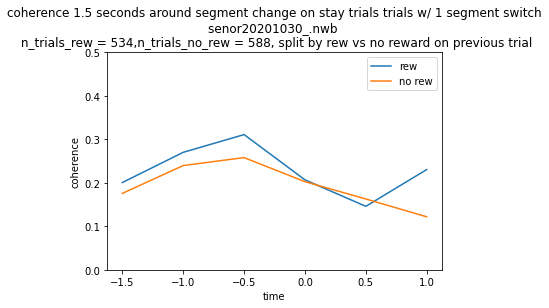

In [19]:
# reward vs no reward previous trial
coher_keeper_rew=[]
time_at_center_last_rew = []
time_at_center_last_no_rew=[]

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix-1].reward==1:
                    time_at_center_last_rew.append(trial_data.iloc[ix].seg_switch_times[0])
                elif trial_data.iloc[ix-1].reward==0: 
                    time_at_center_last_no_rew.append(trial_data.iloc[ix].seg_switch_times[0])

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_rew = get_signal_from_trialtimes(time_at_center_last_rew, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_no_rew = get_signal_from_trialtimes(time_at_center_last_no_rew, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_rew,z_transform_rew,num_tapers = multitaper_and_connectivity(signal_rew,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
# ci_pos_high, ci_neg_high= get_CI(z_transform_high, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_rew.append(coh_seg[0])

plt.plot(time,coher_keeper_rew[0],label=f'rew')
     
               
    
coher_keeper_no_rew=[]

time, freq, mag, power,n_trials_no_rew,z_transform_np_rew,num_tapers = multitaper_and_connectivity(signal_no_rew,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)
# ci_pos_low, ci_neg_low = get_CI(z_transform_low, n_trials, num_tapers)
coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_no_rew.append(coh_seg[0])

plt.plot(time,coher_keeper_no_rew[0],label=f'no rew')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_rew = {n_trials_rew},n_trials_no_rew = {n_trials_no_rew}, split by rew vs no reward on previous trial')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()


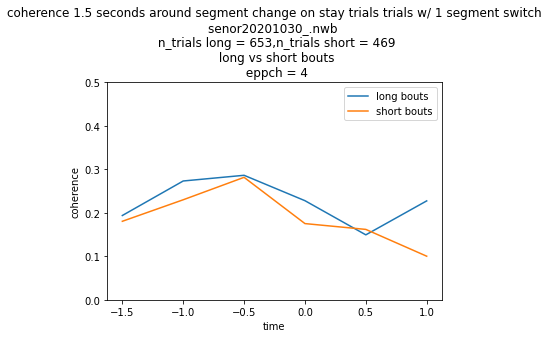

In [21]:
# bout length:
# long vs short bouts
coher_keeper=[]
time_at_center_short_bouts = []
time_at_center_long_bouts=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].bout_lens_per_bout>20:
                    time_at_center_long_bouts.append(trial_data.iloc[ix].seg_switch_times[0])
                else: 
                    time_at_center_short_bouts.append(trial_data.iloc[ix].seg_switch_times[0])
                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_long_bouts = get_signal_from_trialtimes(time_at_center_long_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_short_bouts = get_signal_from_trialtimes(time_at_center_short_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)

    
time, freq, mag, power,n_trials,z_transform_rew,num_tapers = multitaper_and_connectivity(signal_long_bouts,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper.append(coh_seg[0])

n_trials_long = n_trials

plt.plot(time,coher_keeper[0], label = 'long bouts')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n after reward vs no rew')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper=[]
time, freq, mag, power,n_trials,z_transform_rew,num_tapers = multitaper_and_connectivity(signal_short_bouts,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper.append(coh_seg[0])


# plt.figure()
plt.plot(time,coher_keeper[0], label = 'short bouts')
plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials long = {n_trials_long},n_trials short = {n_trials}\n long vs short bouts\n eppch = 4')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5) 
plt.legend()

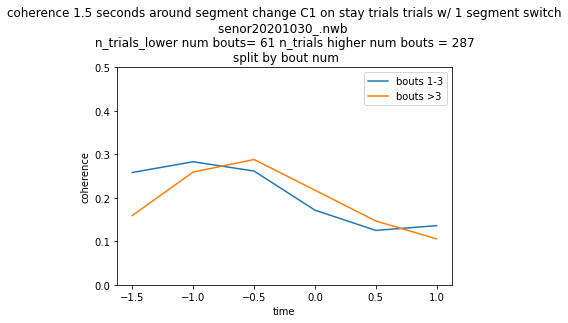

In [12]:
coher_keeper_first=[]
time_at_center_lower_bouts=[]
time_at_center_upper_bouts=[]
# time_at_center_third_cont=[]
# stem='C'

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                if trial_data.iloc[ix].cont_num==1:
                    if trial_data.iloc[ix].bout_num <=3:
                        time_at_center_lower_bouts.append(trial_data.iloc[ix].seg_switch_times[0])
                    else: 
                        time_at_center_upper_bouts.append(trial_data.iloc[ix].seg_switch_times[0])




                    

                    

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]

    
signal_first = get_signal_from_trialtimes(time_at_center_lower_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
signal_second = get_signal_from_trialtimes(time_at_center_upper_bouts, time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)


time, freq, mag, power,n_trials_first,z_transform_rew,num_tapers = multitaper_and_connectivity(signal_first,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_first = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
coher_keeper_first.append(coh_seg_first[0])



plt.plot(time,coher_keeper_first[0],label=f'bouts 1-3')
# plt.title(f'coherence {time_b4} seconds around segment change on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials = {n_trials}\n split by value (H/M/L)')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)        
               
    
coher_keeper_second=[]


time, freq, mag, power,n_trials_second,z_transform_second,num_tapers = multitaper_and_connectivity(signal_second,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

coh_seg_second = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]

coher_keeper_second.append(coh_seg_second[0])



# plt.figure()
plt.plot(time,coher_keeper_second[0],label=f'bouts >3')
plt.title(f'coherence {time_b4} seconds around segment change C1 on stay trials trials w/ 1 segment switch\n{nwb_file_name} \n n_trials_lower num bouts= {n_trials_first} n_trials higher num bouts = {n_trials_second} \n split by bout num')#high value (>.66)')
plt.xlabel('time') 
plt.ylabel('coherence')                
plt.ylim(0,.5)
plt.legend()

In [19]:
import math
print (f'original: ntrials = {n_trials_second}, num_tapers = {num_tapers}')
print(f'original z transformed coherence {z_transform_rew_second}')
ci_pos_orig, ci_neg_orig = get_CI(z_transform_rew_second, n_trials_second, num_tapers)
print(f'ci_pos with original z scores = {ci_pos_orig}')
tanh_z_trans = []
for ix in range(len(z_transform_rew_second)):
    one_point= z_transform_rew_second[ix]
    tanh_z_trans.append(math.tanh(one_point))
print(f'tanh(z transform) = {tanh_z_trans}')
ci_pos_tanh, ci_neg_tanh = get_CI(tanh_z_trans, n_trials_second, num_tapers)
print(f'ci_pos with tanh z scores = {ci_pos_tanh}')




original: ntrials = 287, num_tapers = 2
original z transformed coherence [14.2749779  18.98025298 20.26844934 17.08663368 13.63629572 11.38548425]
ci_pos with original z scores = [14.332875928786923, 19.03815101003416, 20.32634736240237, 17.144531710247787, 13.69419374294223, 11.443382272096795]
tanh(z transform) = [0.9999999999992021, 0.9999999999999999, 1.0, 0.9999999999999971, 0.9999999999971378, 0.999999999741938]
ci_pos with tanh z scores = [1.0578980267434064, 1.0578980267442042, 1.0578980267442044, 1.0578980267442015, 1.0578980267413423, 1.0578980264861424]


In [20]:
math.tanh(14.332875928786923)

0.9999999999992893

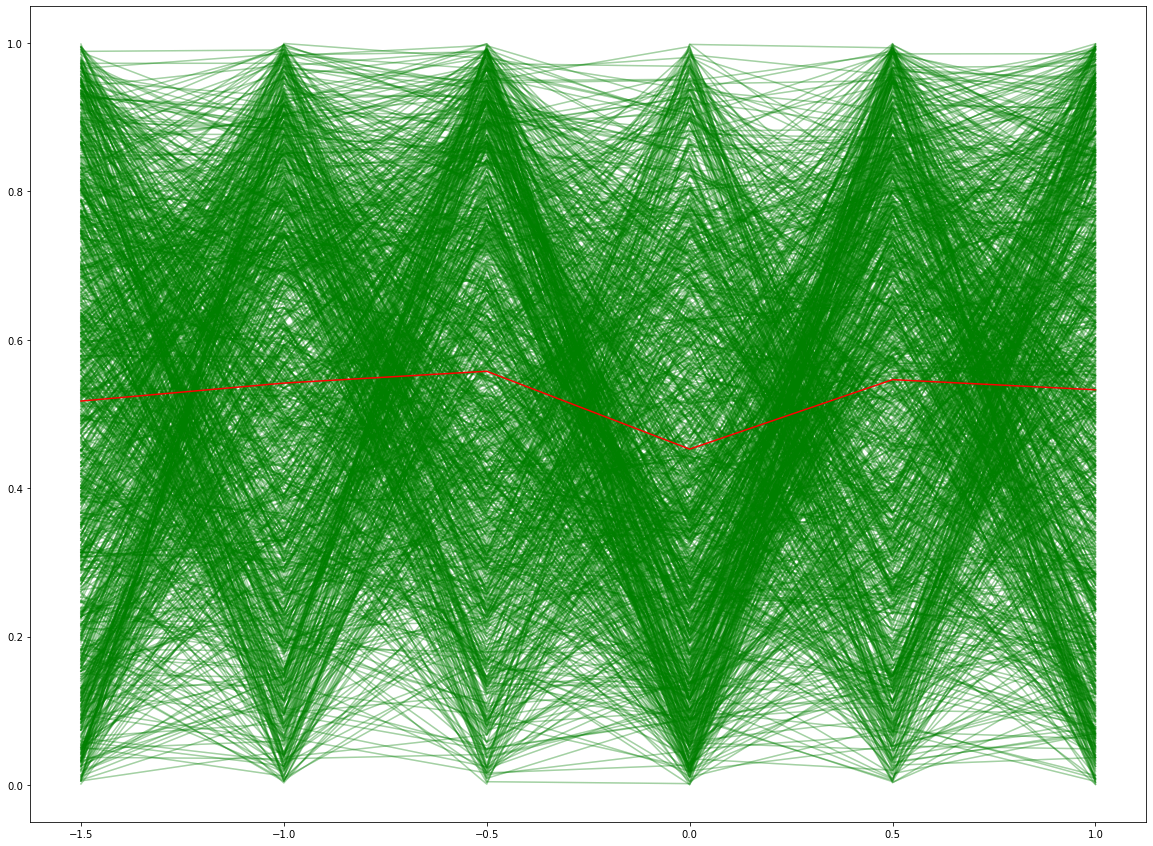

In [63]:
# this will do each trial individually and i dont understand the results 
plt.figure(figsize=(20,15))

coher_keeper=[]
coher_keeper1=[]
time_at_center=[]
signal_keeper=[]

for ix in range(1,len(trial_data)): 
    if trial_data.iloc[ix].seg_switch_times!=0:
        if trial_data.iloc[ix].stem_switch==False: 
            if len(trial_data.iloc[ix].seg_switch_times) ==1:
                time_at_center.append(trial_data.iloc[ix].seg_switch_times[0])

time_b4 = time_after = 1.5
electrode_id_temp =[8,132]


for ix in range(len(time_at_center)):
    time_at_center_single_trial = time_at_center[ix]
    signal = get_signal_from_trialtimes([time_at_center_single_trial], time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
    signal_keeper.append(signal)
    time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

    coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
    coher_keeper.append(coh_seg[0])
    plt.plot(time,coh_seg[0],color='g',alpha=.2)

for ix in range(len(coher_keeper)):
    plt.plot(time,coher_keeper[ix],color='g',alpha=.2)
    coher_keeper1.append(coher_keeper[ix].tolist())
coher_keeper1 = np.array(coher_keeper1)
mean_coherence = np.average(coher_keeper1, axis=0)
    
plt.plot(time,mean_coherence,color='r')


In [64]:
trial_data.epoch.max()

14

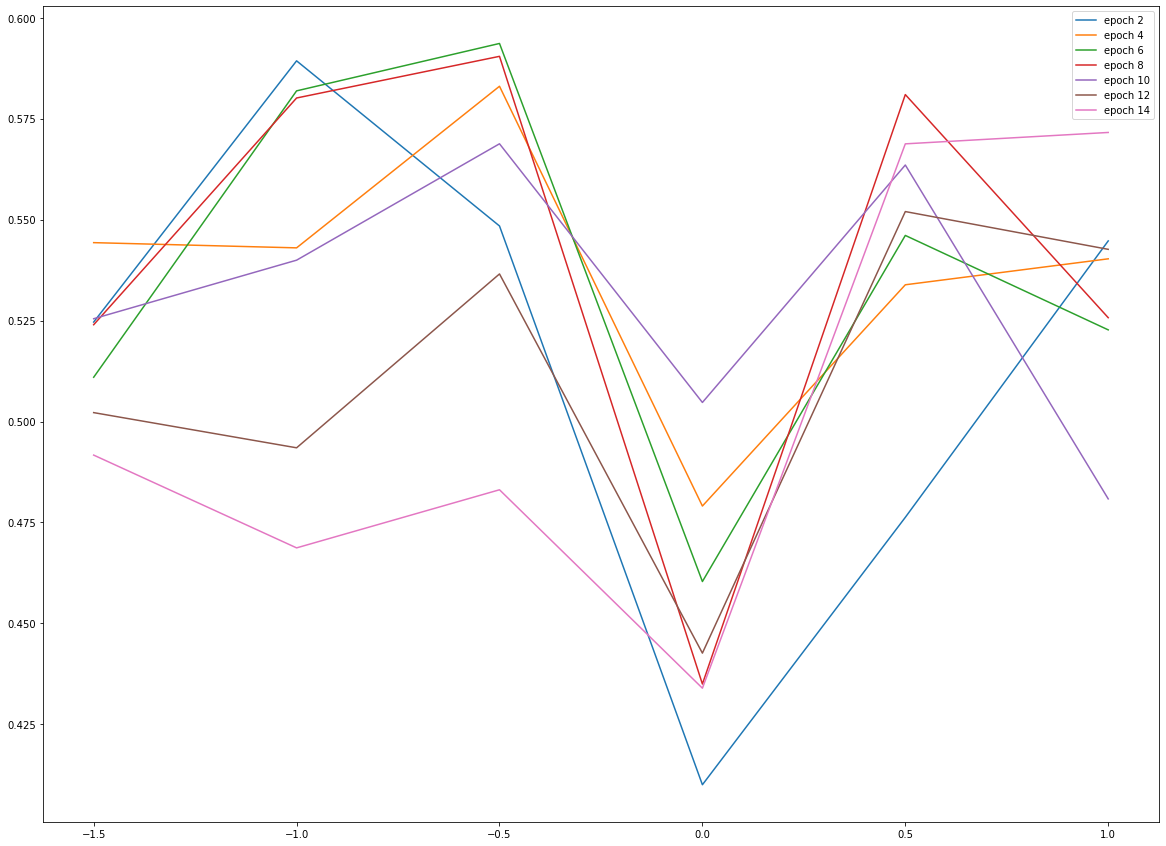

In [74]:
plt.figure(figsize=(20,15))


for epoch_num in range(2,trial_data.epoch.max()+2,2):
    coher_keeper=[]
    coher_keeper1=[]
    time_at_center=[]
    signal_keeper=[]
    epoch_df = trial_data[trial_data.epoch==epoch_num]
    # plt.figure()
    for ix in range(1,len(epoch_df)): 
        if epoch_df.iloc[ix].seg_switch_times!=0:
            if epoch_df.iloc[ix].stem_switch==False: 
                if len(epoch_df.iloc[ix].seg_switch_times) ==1:
                    time_at_center.append(epoch_df.iloc[ix].seg_switch_times[0])

    time_b4 = time_after = 1.5
    electrode_id_temp =[8,132]

    for ix in range(len(time_at_center)):
        time_at_center_single_trial = time_at_center[ix]
        signal = get_signal_from_trialtimes([time_at_center_single_trial], time_b4,time_after, electrode_id_temp, lfp_eseries, lfp_timestamps, lfp_data)
        signal_keeper.append(signal)
        time, freq, mag, power,n_trials,z_transform,num_tapers = multitaper_and_connectivity(signal,sampling_frequency,time_halfbandwidth_product,time_window_duration,time_window_step,-time_b4)

        coh_seg = mag()[..., 0, 1].squeeze().T[(freq[0] == 8)]
        coher_keeper.append(coh_seg[0])
        # plt.plot(time,coh_seg[0],color='g',alpha=.2)

    for ix in range(len(coher_keeper)):
        # plt.plot(time,coher_keeper[ix],color='g',alpha=.2)
        coher_keeper1.append(coher_keeper[ix].tolist())
    coher_keeper1 = np.array(coher_keeper1)
    mean_coherence = np.average(coher_keeper1, axis=0)

    plt.plot(time,mean_coherence,label=f'epoch {epoch_num}')
plt.legend()



In [70]:
coher_keeper1

array([], dtype=float64)